In [10]:
!C:/lidar_env/Scripts/pip install geopandas

The system cannot find the path specified.


In [11]:
#!C:/lidar_env/Scripts/pip install trame

In [12]:
import numpy as np
import open3d as o3d
import laspy

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [13]:
# Load LiDAR data
file_path = r"als_33304-5862\als_33304-5862.laz"
las_data = laspy.read(file_path)

# List all available point attributes in the file
print("Available attributes in the .laz file:")
for dimension in las_data.point_format.dimensions:
    print(dimension.name)

Available attributes in the .laz file:
X
Y
Z
intensity
return_number
number_of_returns
synthetic
key_point
withheld
overlap
scanner_channel
scan_direction_flag
edge_of_flight_line
classification
user_data
scan_angle
point_source_id
gps_time


Classification Codes and Frequencies:
Class 0: 5051226 points
Class 2: 10444732 points
Class 20: 2889020 points


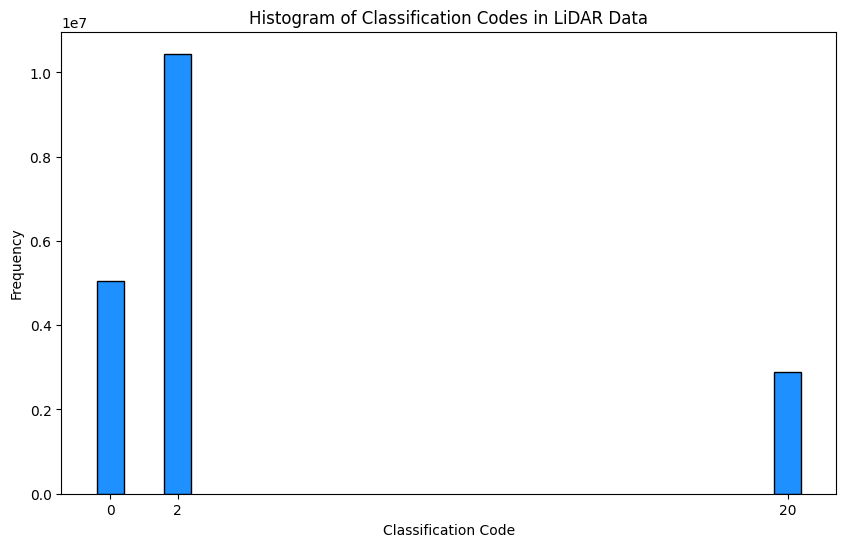

In [14]:

classification = np.array(las_data.classification)

# Get unique classification codes and their counts
unique_classes, counts = np.unique(classification, return_counts=True)
class_frequencies = dict(zip(unique_classes, counts))

# Print classification information
print("Classification Codes and Frequencies:")
for class_code, freq in class_frequencies.items():
    print(f"Class {class_code}: {freq} points")

# Plot a histogram for classification
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, counts, color='dodgerblue', edgecolor='black')
plt.xlabel("Classification Code")
plt.ylabel("Frequency")
plt.title("Histogram of Classification Codes in LiDAR Data")
plt.xticks(unique_classes)
plt.show()


In [15]:
# Extract x, y, z coordinates and classification
points = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()
classification = las_data.classification  # Get the classification codes

# Define subsampling ratio
subsample_ratio = 0.2  # Adjust as needed for performance
sample_size = int(len(points) * subsample_ratio)
indices = np.random.choice(points.shape[0], sample_size, replace=False)

# Subsample points and their classifications
subsampled_points = points[indices]
subsampled_classification = classification[indices]

# Separate subsampled points by classification
ground_points = subsampled_points[subsampled_classification == 2]
vegetation_points = subsampled_points[subsampled_classification == 20]
unclassified_points = subsampled_points[subsampled_classification == 0]


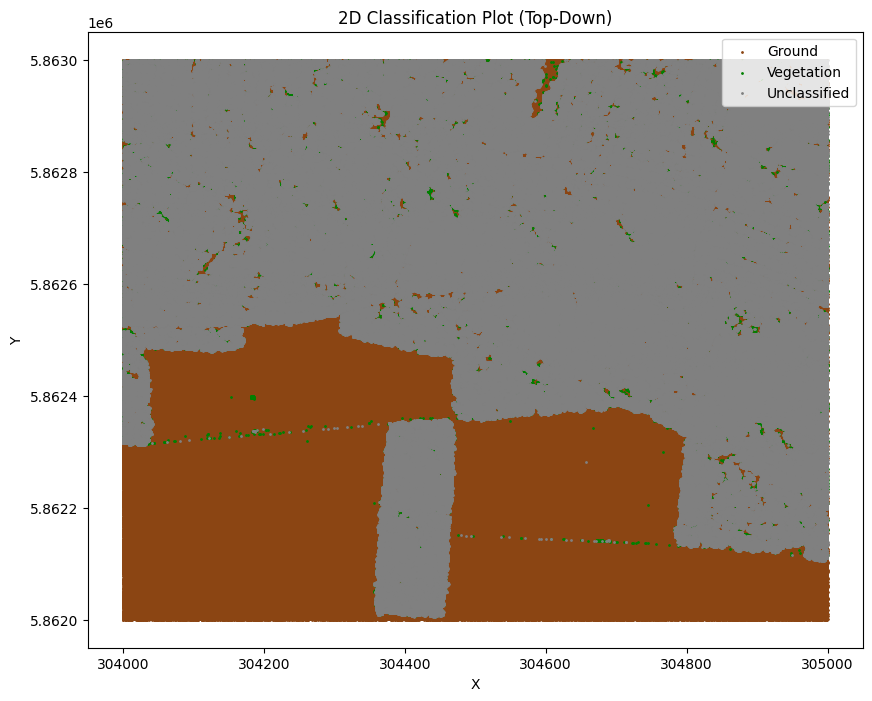

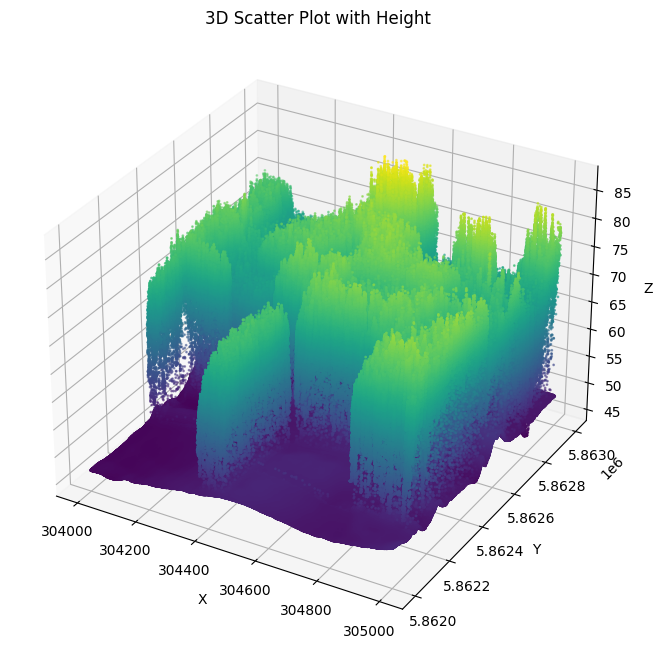

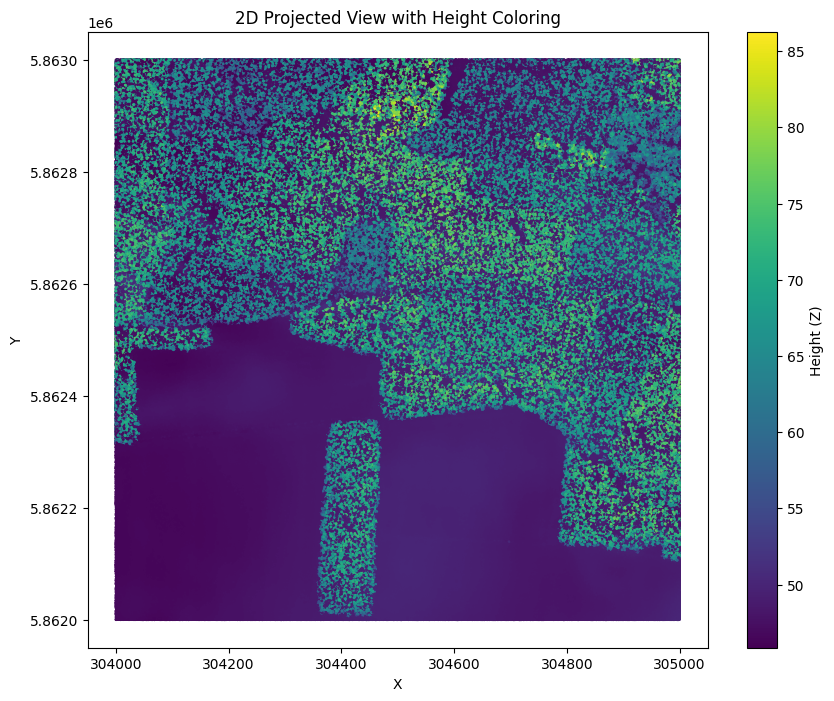

In [16]:
# 2D Plot using x and y coordinates
plt.figure(figsize=(10, 8))
plt.scatter(ground_points[:, 0], ground_points[:, 1], c='saddlebrown', s=1, label='Ground')
plt.scatter(vegetation_points[:, 0], vegetation_points[:, 1], c='green', s=1, label='Vegetation')
plt.scatter(unclassified_points[:, 0], unclassified_points[:, 1], c='gray', s=1, label='Unclassified')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc="upper right")
plt.title("2D Classification Plot (Top-Down)")
plt.savefig("lidar_classification_visualization_2d.png", dpi=300)
plt.show()

# 3D Plot using x, y, and z coordinates
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    subsampled_points[:, 0], 
    subsampled_points[:, 1], 
    subsampled_points[:, 2], 
    c=subsampled_points[:, 2], 
    cmap='viridis', 
    s=1
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("3D Scatter Plot with Height")
plt.show()

# 2D Projection (Flattening Z-axis)
plt.figure(figsize=(10, 8))
plt.scatter(subsampled_points[:, 0], subsampled_points[:, 1], c=subsampled_points[:, 2], cmap="viridis", s=1)
plt.colorbar(label="Height (Z)")
plt.xlabel('X')
plt.ylabel('Y')
plt.title("2D Projected View with Height Coloring")
plt.savefig("lidar_2d_projection_view.png", dpi=300)
plt.show()


In [17]:
from pyproj import Transformer
import folium

# Initialize the transformer with correct projections (UTM to WGS84)
transformer = Transformer.from_crs("epsg:25833", "epsg:4326", always_xy=True)

# Define bounding box in UTM (EPSG:25833)
xmin, ymin, min_z = las_data.header.min
xmax, ymax, max_z = las_data.header.max

# Convert the UTM coordinates to latitude and longitude
min_lon, min_lat = transformer.transform(xmin, ymin)
max_lon, max_lat = transformer.transform(xmax, ymax)

# Calculate the center point for map centering
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

# Create a folium map centered on the bounding box with satellite tiles
m = folium.Map(location=[center_lat, center_lon], zoom_start=15, tiles="OpenStreetMap")

# Add an overlay of satellite imagery using Esri World Imagery
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Satellite",
    overlay=True,
    control=True,
).add_to(m)

# Draw the bounding box on the map
folium.Rectangle(
    bounds=[(min_lat, min_lon), (max_lat, max_lon)],
    color="blue",
    fill=True,
    fill_opacity=0.2
).add_to(m)

# Add layer control to toggle between map layers
folium.LayerControl().add_to(m)

# Display the map in Jupyter Notebook
m


In [18]:
from PIL import Image
import os

# Get list of all .png files in the current directory, case-insensitive
image_files = [f for f in os.listdir() if f.lower().endswith('.png')]

# Ensure there are images to process
if image_files:
    # Open images and convert to RGB (required for PDF)
    images = [Image.open(img).convert("RGB") for img in image_files]

    # Save as a single PDF file
    images[0].save("merged_images.pdf", save_all=True, append_images=images[1:])
    print("PDF created successfully as 'merged_images.pdf'")
else:
    print("No PNG files found in the current directory.")


PDF created successfully as 'merged_images.pdf'


In [19]:
image_files

['3d_point_cloud_static.png',
 'Capture.PNG',
 'Capture2.PNG',
 'Capture3.PNG',
 'lidar_2d_projection_view.png',
 'lidar_classification_visualization.png',
 'lidar_classification_visualization_2d.png',
 'output.png']